In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm
import re
%matplotlib inline

#### Notebook parameters

In [175]:
# Path to the training data
DATA_PATH = 'data/medium_articles.csv'

# Path to pretrained word embeddings
EMBEDDING_PATH = 'data/glove.6B/glove.6B.100d.txt'

#### Data analysis

In [35]:
# Read in training data
data = pd.read_csv(DATA_PATH)

# Create date column
data['date'] = pd.to_datetime(data['timestamp'].map(lambda x: str(x)[0:10]))

print(data.shape)
data.head()

(192368, 7)


,title,text,url,authors,timestamp,tags,date
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci...",2020-12-26
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P...",2020-09-23
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We...",2020-10-10
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P...",2020-12-21
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology...",2020-02-26


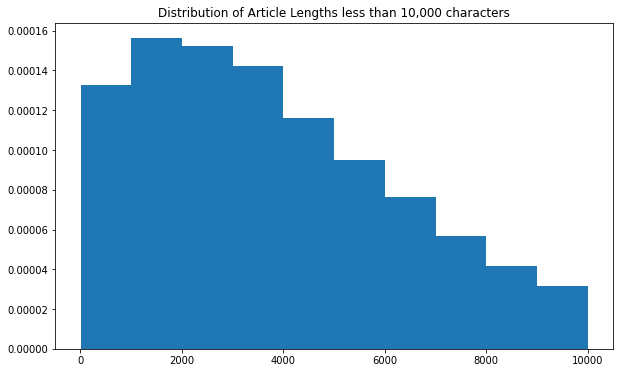

count    192368.000000
mean       5097.748134
std        5206.093120
min          10.000000
25%        1952.000000
50%        3837.000000
75%        6591.000000
max      100000.000000
Name: article_length, dtype: float64

In [36]:
# Analyze distribution of article and title lengths
data['article_length'] = data['text'].str.len()
data['title_length'] = data['title'].str.len()

fig,ax = plt.subplots(figsize=(10,6))
out = ax.hist(data[data['article_length'] < 10000]['article_length'], density=True) 
ax.set_title('Distribution of Article Lengths less than 10,000 characters')
plt.show()

data['article_length'].describe()

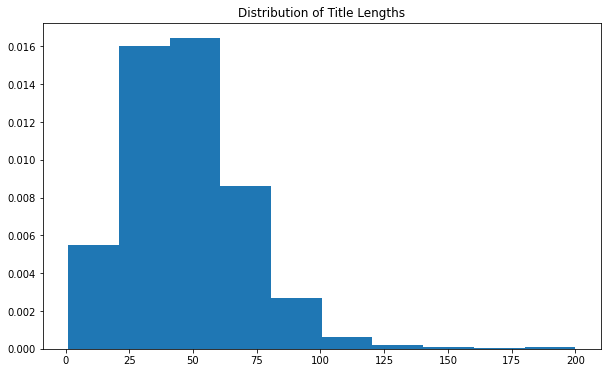

count    192363.000000
mean         46.878828
std          23.178936
min           1.000000
25%          31.000000
50%          45.000000
75%          60.000000
max         200.000000
Name: title_length, dtype: float64

In [37]:
fig,ax = plt.subplots(figsize=(10,6))
out = ax.hist(data['title_length'], density=True) 
ax.set_title('Distribution of Title Lengths')
plt.show()

data['title_length'].describe()

#### Data preparation

In [194]:
# TODO: Optimize some of these functions to not use pure python
def remove_newlines_tabs(text):
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    return text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('  ', ' ')

def remove_links(text):
    
    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    
    remove_www = re.sub(r'www\S+', '', remove_https)
    
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_www)
    
    return remove_com

def remove_special_characters(text):

    return re.sub(r"[^a-zA-Z0-9:$-%’]+", ' ', text) 

def clean_text_input(text, size_limit:int=None):
    
    clean_text = text
    clean_text = remove_newlines_tabs(clean_text)
    clean_text = remove_links(clean_text)
    clean_text = remove_special_characters(clean_text)

    if size_limit:

        clean_text = clean_text[0:size_limit]

    return clean_text.lower()

In [195]:
# Add clean text column
data['cleaned_text'] = data['text'].map(lambda t: clean_text_input(t))
data['cleaned_title'] = data['title'].str.lower()
data.dropna(inplace=True)
print(data.shape)
data.head()

(192361, 12)


,title,text,url,authors,timestamp,tags,date,article_length,title_length,cleaned_text,cleaned_title,reduced_cleaned_text
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci...",2020-12-26,5018,19.0,photo by josh riemer on unsplash merry christm...,mental note vol. 24,photo by josh riemer on unsplash merry christm...
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P...",2020-09-23,7293,25.0,your brain on coronavirus a guide to the curio...,your brain on coronavirus,your brain on coronavirus a guide to the curio...
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We...",2020-10-10,5730,14.0,mind your nose how smell training can change y...,mind your nose,mind your nose how smell training can change y...
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P...",2020-12-21,146,24.0,passionate about the synergy between science a...,the 4 purposes of dreams,passionate about the synergy between science a...
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology...",2020-02-26,2326,32.0,you’ve heard of him haven’t you phineas gage t...,surviving a rod through the head,"you’ve heard of him, haven’t you? phineas gage..."


In [196]:
class SpecialToken(Enum):
    
    SOS = 0
    EOS = 1
    PAD = 2
    UNK = 3
    
MAX_TEXT_LENGTH = 5000

class Lang:
    
    def __init__(self):
        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SpecialToken.SOS.value: "<SOS>",
                           SpecialToken.EOS.value: "<EOS>",
                           SpecialToken.PAD.value: "<PAD>",
                           SpecialToken.UNK.value: "<UNK>"}
        
        self.n_words = len(SpecialToken)
        
    def add_text(self, text):
        
        for word in text.split(' '):
            
            self.add_word(word)
            
    def add_word(self, word):
        
        if word not in self.word2index:
            
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
            
        else:
            
            self.word2count[word] += 1

In [197]:
# Create vocab object
VOCAB = Lang()

# Add article words to vocab
for article in tqdm(data['cleaned_text'].values):
    
    VOCAB.add_text(article)
    
# Add title words to vocab
for title in tqdm(data['cleaned_title'].values):
    
    VOCAB.add_text(title)
    

100%|███████████████████████████████| 192361/192361 [00:01<00:00, 138401.28it/s]


In [198]:
print(VOCAB.n_words)
print(VOCAB.word2index['harrison'])
print(VOCAB.index2word[23554])

793355
15936
kurosawa


In [199]:
# Only going to use first 5000 characters of each article to train the model
data['reduced_cleaned_text'] = data['cleaned_text'].map(lambda t: t[0:MAX_TEXT_LENGTH])
data['reduced_cleaned_text'].str.len().max()

5000

In [200]:
# Read in word embeddings
glove = pd.read_csv(EMBEDDING_PATH, sep=" ", quoting=3, header=None, index_col=0)

# Create an embedding for unknown tokens that is the average of all embeddings
glove_unknown = pd.DataFrame(glove.mean()).T
glove_unknown.index = [VOCAB.index2word[SpecialToken.UNK.value]]

glove = pd.concat([glove, glove_unknown])

glove_embedding = {key: val.values for key, val in glove.T.items()}

len(glove_embedding)

400000

In [201]:
glove_embedding[VOCAB.index2word[SpecialToken.UNK.value]]

array([ 0.0520989 , -0.09711571, -0.13807639,  0.11075364, -0.02722782,
       -0.00326489,  0.03176443, -0.05076858,  0.15321673, -0.02367416,
       -0.00785459,  0.08436052, -0.08042076, -0.08836834, -0.01713606,
        0.07352568, -0.16472259,  0.05473623,  0.15367079, -0.05283972,
       -0.16474463, -0.00894968, -0.13604211, -0.03889302, -0.09204676,
        0.02874561,  0.02445903,  0.1941931 , -0.03298016,  0.00509298,
        0.01469093, -0.15542818,  0.03542845, -0.02936221,  0.01372915,
       -0.06067601,  0.02025433, -0.14560258,  0.05823825,  0.01729521,
        0.16282154,  0.18634708, -0.0633775 ,  0.13067349, -0.11122712,
        0.02721625,  0.03867919,  0.15675569,  0.01345032,  0.19424636,
       -0.01218781,  0.03659266, -0.08235352, -0.24420501,  0.07523874,
        0.46423066,  0.06318566,  0.05081312, -0.38146976, -0.20739795,
        0.03489537, -0.18234721,  0.09021401, -0.02504146, -0.22256527,
        0.03383004, -0.1337939 , -0.14375436, -0.11264266, -0.03

In [207]:
# Add orthogonal embeddings for <PAD>, <SOS>, and <EOS>
glove_embedding[VOCAB.index2word[SpecialToken.PAD.value]] = np.eye(100)[0]
glove_embedding[VOCAB.index2word[SpecialToken.SOS.value]] = np.eye(100)[1]
glove_embedding[VOCAB.index2word[SpecialToken.EOS.value]] = np.eye(100)[2]

In [210]:
glove_embedding['<EOS>']

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [211]:
def create_embedding_matrix(word_index, embedding_dict, dimension, unknown_token):
    
    embedding_matrix = np.zeros((len(word_index)+1, dimension))
    
    known_tracker = []

    for word, index in word_index.items():
    
        if word in embedding_dict:
        
            embedding_matrix[index] = embedding_dict[word]
            known_tracker.append(1)
            
        else:
            
            embedding_matrix[index] = embedding_dict[unknown_token]
            known_tracker.append(0)
            
    print(f'{(1-np.mean(known_tracker))*100}% of words did not have embeddings')
            
    return embedding_matrix

In [212]:
embedding_matrix = create_embedding_matrix(VOCAB.word2index, embedding_dict=glove_embedding, dimension=100)
embedding_matrix.shape

KeyError: '_UNK'